In [2]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import datetime
from datetime import timedelta
from datetime import date


import re
import time
import stat
import contextlib
import functools

import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED

from fbprophet import Prophet
import urllib
import urllib.request
import pandas_market_calendars as mcal
import os.path
from os import path
from functools import reduce
#import pandas-datareader
#import mpl-finance
#from fbprophet.diagnostics import cross_validation
#rom fbprophet import Prophet
import stockstats
from stockstats import StockDataFrame
import tabulate
import mplfinance as mpf
import matplotlib.dates as mdates
import statsmodels.tsa.stattools as ts
from hurst import compute_Hc

import os.path
from os import path

pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely

from finta import TA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline
from sklearn.metrics import mean_squared_error

from scipy.stats import ttest_ind

/usr/local/lib/python3.6/dist-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



In [3]:
n_forward = 7

#name = 'GLD'
#name = 'SPY'
#name = 'GOOG'

#strategy = "EMA"
strategy = "SMA"
#indicator = 'Close'
indicator = 'VWP'

w=117
end_date = datetime.date.today()
#end_date = datetime.date.today() - timedelta(weeks=w)
end_date1 = end_date - timedelta(weeks=w)

#- timedelta(weeks=w*2)
start_date = end_date1 - timedelta(weeks=w)

benchName = "^GSPC"
bench = yf.Ticker(benchName)
#bench Data needs to be +1 because it ends the day before end_date
benchData = bench.history(interval="1d",start=start_date,end=end_date+timedelta(days=1), auto_adjust=True)


In [4]:

dateindex = benchData.loc[start_date:end_date].index
dateindex_n_forward = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward+5))-start_date).days)]

#dateindex2 = benchData.loc[end_date1:end_date].index

#dateindex2_n_foward = [end_date1 + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-end_date1).days)]

nyse = mcal.get_calendar('NYSE')

nyse_trading_dates= nyse.schedule(start_date=start_date, end_date=(end_date+timedelta(days=n_forward+3)))



/usr/local/lib/python3.6/dist-packages/pandas/core/internals/construction.py:791: FutureWarning:

Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.



In [5]:
#if(len(data)==len(dateindex_)):
if(len(benchData)>len(nyse_trading_dates)):
    frequency=pd.DataFrame(dateindex_n_forward).set_index(0)
    
else:
    frequency=nyse_trading_dates.rename_axis([None]).index
    


In [6]:
#will help later with bad data during loops

prices = benchData
df = prices.rename_axis([None]).reindex(frequency)
df = df.interpolate(method='linear')
benchData = df[start_date:end_date]


In [7]:
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return(unique_list)

In [8]:
pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely

cores = int(len(os.sched_getaffinity(0)))

pool1 = concurrent.futures.ProcessPoolExecutor(cores)

one_week_end = start_date
one_week_start = one_week_end - timedelta(weeks=1)

#need to do the two pass trick (i.e. find stocks fully populated a week 9 quarters back)

nyse = mcal.get_calendar('NYSE')
official_trading_dates= nyse.schedule(start_date=start_date, end_date=end_date)

date_time_obj_start = start_date

date_time_obj_end = end_date

one_week_trading_dates = nyse.schedule(start_date=one_week_start, end_date=one_week_end)

url = 'ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt'

#should turn this into a function
if path.exists("nasdaqtraded.txt"):
    print("file exists")
    
    filePath = 'nasdaqtraded.txt'
    fileStatsObj = os.stat ( filePath )
    modificationTime = time.ctime ( fileStatsObj [ stat.ST_MTIME ] )

    print("Last Modified Time : ", modificationTime )

    a = datetime.datetime.strptime(modificationTime, "%a %b %d %H:%M:%S %Y")

    if a.date() != datetime.date.today():
        print("not same dates downloading")
        urllib.request.urlretrieve(url, 'nasdaqtraded.txt')
        urllib.request.urlretrieve(url, 'mfundslist.txt')
        urllib.request.urlretrieve(url, 'bonds.txt')
    else:
      print("equal dates, not redownloading")
    
else:
    print("downloading nasdaqtraded.txt")
    urllib.request.urlretrieve(url, 'nasdaqtraded.txt')
    urllib.request.urlretrieve(url, 'mfundslist.txt')
    urllib.request.urlretrieve(url, 'bonds.txt')
    
df1 = pd.read_csv('nasdaqtraded.txt', sep='|')[0:-1]
df2 = pd.read_csv('mfundslist.txt', sep='|')[0:-1]
df3 = pd.read_csv('bonds.txt', sep='|')[0:-1]

#process symbols for bad characters
BAD_CHARS = ['$','.']
pat = '|'.join(['({})'.format(re.escape(c)) for c in BAD_CHARS])

df1 = df1[~df1['Symbol'].str.contains(pat)]
df2 = df2[~df2['Symbol'].str.contains(pat)]
df3 = df3[~df3['Symbol'].str.contains(pat)]

#choose size
size=500
#stocks = list(df1["Symbol"].sample(n=int(size/3)))
stocks = list(df1["Symbol"].sample(n=int(size)))
mfunds = list(df2["Symbol"].sample(n=int(size/3)))
bonds = list(df3["Symbol"].sample(n=int(size/3)))
#symbols = unique(stocks + mfunds + bonds)
symbols = unique(stocks)

def dl_one_week(stock):
    return yf.download(stock, start=one_week_start, end=one_week_end, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')

def dl(stock):
    return yf.download(stock, start=start_date, end=end_date+timedelta(days=1), auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')

def processStocks(symbols):

    futures1 = [pool1.submit(dl_one_week, args) for args in symbols]
    wait(futures1, timeout=None, return_when=ALL_COMPLETED)

    symbols_data_one_week = pd.DataFrame()

    for x in range(0,len(symbols)):
        prices = pd.DataFrame(futures1[x].result())
        prices['Symbol'] = symbols[x]
        prices = prices.loc[~prices.index.duplicated(keep='last')]        
        prices = prices.reset_index()

        symbols_data_one_week = pd.concat([symbols_data_one_week,prices])

    #symbols_data_one_week

    #stocks that existed 9 quarters ago
    vetted_symbols = list(symbols_data_one_week.Symbol.unique())

    pool2 = concurrent.futures.ProcessPoolExecutor(cores)

    futures2 = [pool2.submit(dl, args) for args in vetted_symbols]
    wait(futures2, timeout=None, return_when=ALL_COMPLETED)    

    symbols_data = pd.DataFrame()
    
    #Have to interpolate later
    for x in range(0,len(vetted_symbols)):
        prices = pd.DataFrame(futures2[x].result())
        prices['Symbol'] = vetted_symbols[x]
        prices = prices.loc[~prices.index.duplicated(keep='last')]        
        prices = prices.reset_index()

        #idx1 = prices.index  
        
        #df = prices.rename_axis([None]).reindex(frequency)

        #for d in prices.rename_axis([None]).index:
            #df.loc[d] = prices.loc[d]

        #df.interpolate(method='linear')
        
        #merged = idx1.union(frequency)
        #s = prices.reindex(merged)
        #df = s.interpolate().dropna(axis=0, how='any')

        #if len(df) == len(prices.index):
        symbols_data = pd.concat([symbols_data,prices])
            
    symbols_data.to_csv('symbols_data.csv', index = False)

if path.exists('symbols_data.csv'):
    print("data exists")
    
    filePath = 'symbols_data.csv'
    fileStatsObj = os.stat ( filePath )
    modificationTime = time.ctime ( fileStatsObj [ stat.ST_MTIME ] )

    print("Last Modified Time : ", modificationTime )

    a = datetime.datetime.strptime(modificationTime, "%a %b %d %H:%M:%S %Y")

    if a.date() != datetime.date.today():
        print("not same dates downloading stocks")
        
        processStocks(symbols)
        
    else:
        print("equal dates, not redownloading")
    
else:
    print("downloading symbols")
    processStocks(symbols)
    


file exists
Last Modified Time :  Wed Mar 10 08:30:53 2021
equal dates, not redownloading
data exists
Last Modified Time :  Wed Mar 10 08:31:17 2021
equal dates, not redownloading


/usr/local/lib/python3.6/dist-packages/pandas/core/internals/construction.py:791: FutureWarning:

Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.

/usr/local/lib/python3.6/dist-packages/pandas/core/internals/construction.py:791: FutureWarning:

Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1843: UserWarning:

This pattern has match groups. To actually get the

In [9]:
#symbols = ['BTC-USD']
#processStocks(symbols)

symbols_data = pd.read_csv('symbols_data.csv', sep=',')[0:-1]
vetted_symbols = symbols_data.Symbol.unique()


In [10]:
symbols_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol'], dtype='object')

In [11]:
returnsdf = pd.DataFrame()
returnsl = []

#cumulative returns of 1st half
for i in vetted_symbols:
    subset = symbols_data[symbols_data["Symbol"]==i]
    subset = subset.set_index('Date')[start_date.strftime('%Y-%m-%d'):end_date1.strftime('%Y-%m-%d')]
    
    #print(subset)
    price_data = subset["Close"]
    #print(price_data)
    
    ret_data = price_data.pct_change()[1:]
    
    cumulative_ret = (ret_data + 1).cumprod()
    
    last = cumulative_ret.iloc[-1]
    
    #pd.concat(last,returns)
    returnsl.append(last)

    #plt.plot(cumulative_ret, label=i)
    #plt.legend(loc="upper left",fontsize=8)
    
returnsdf["returns"] = returnsl
returnsdf["stock"] = vetted_symbols

returnsdf = returnsdf.sort_values(by=['returns'], ascending=False)

XPercent = .1
cutoff = round(len(returnsdf)*XPercent,0)

topXPercent = returnsdf['stock'][0:int(cutoff)]
topXPercent

305    AMPY
181    MDGL
225    BLFS
176    ESPR
210     RNG
278    SRPT
254    KALV
197    AVAV
294     IMV
94      HAE
200    HTHT
133    ANET
46     ARNA
35     OLLI
177    FIVE
149    OPNT
306    VNOM
236    FTNT
14     ARKK
162    EDIT
112    ITIC
299    TWTR
146    CPRT
92      MSA
159    WDAY
290    CRMT
271    TSLA
270    IONS
4      ROLL
238    CEQP
98     CRVL
Name: stock, dtype: object

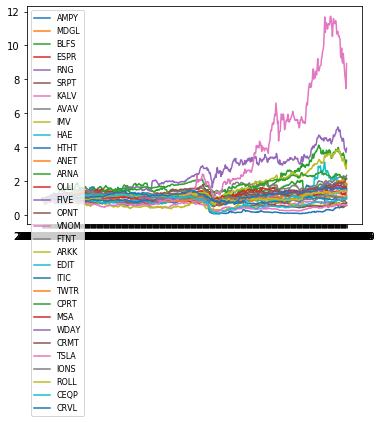

In [12]:
#cumulative returns over test period

for i in topXPercent:
    subset = symbols_data[symbols_data["Symbol"]==i]
    subset = subset.set_index('Date')[(end_date1+timedelta(days=1)).strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]
    
    #print(subset)
    price_data = subset["Close"]
    #print(price_data)
    
    ret_data = price_data.pct_change()[1:]
    
    cumulative_ret = (ret_data + 1).cumprod()
    
    last = cumulative_ret.iloc[-1]
    
    #pd.concat(last,returns)
    returnsl.append(last)

    plt.plot(cumulative_ret, label=i)
    plt.legend(loc="upper left",fontsize=8)

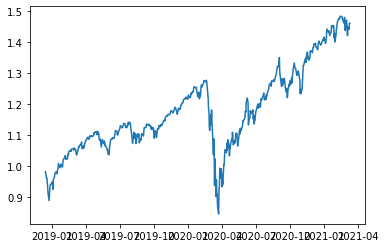

In [13]:
limit = 100

train_size = 0.5

#minExpectedReturn = 0.0005
minExpectedReturn = 0.0

#width1 = len(nyse_trading_dates[start_date:end_date1].index)

#not doing any sales here, so is the +1 necessary?
#even if doing +1 I don't want to use timedelta, but it's okay to use it becuase at most it's +1 actual day (vs trading day) and the filtering will still work
#width2 = len(data.loc[end_date1+timedelta(days=1):end_date].index)
width2 = len(nyse_trading_dates[end_date1+timedelta(days=1):end_date].index)


#dateindex = benchData.loc[start_date:end_date].index
#returnsdf[0:int(cutoff)]

dateindex = benchData.loc[start_date:end_date].index
dateindex_ = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date)-start_date).days)]
dateindex_n_forward = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-start_date).days)]

#dateindex2 = benchData.loc[end_date1:end_date].index

#dateindex2_n_foward = [end_date1 + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-end_date1).days)]

sp500_data = benchData[end_date1+timedelta(days=1):end_date]['Close'].pct_change()
sp500_cumulative_ret_data = (sp500_data + 1).cumprod()
plt.plot(sp500_cumulative_ret_data,label="bench: " + benchName)


In [14]:
len(benchData)
#benchData.iloc[-1]
#len(idx2)

1129

In [19]:
#for symbol in topXPercent[7:8]:
def processSets(symbol):

    subset = symbols_data[symbols_data["Symbol"]==symbol].dropna()        
    
    subset = subset.set_index('Date')
    width1 = len(subset[subset.index.get_loc(start_date.strftime('%Y-%m-%d')):subset.index.get_loc(end_date1.strftime('%Y-%m-%d'))])
    
    subset['Forward Close'] = subset['Close'].shift(-n_forward)
    subset['Forward Return'] = (subset['Forward Close'] - subset['Close'])/subset['Close']
    subset['VWP'] = subset['Close']*subset['Volume']
    
    Short_EVWMA = pd.DataFrame(TA.EVWMA(subset,12))
    Long_EVWMA = pd.DataFrame(TA.EVWMA(subset,26))
    Short_EVWMA.columns = ['EVWMA_12']
    Long_EVWMA.columns = ['EVWMA_26']

    #p 209 of ttr doc
    MACD_EVWMA = pd.DataFrame((Short_EVWMA['EVWMA_12'] - Long_EVWMA['EVWMA_26'])/Long_EVWMA['EVWMA_26'])
    MACD_EVWMA.columns = ['MACD-line']

    Signal_EVWMA = pd.DataFrame(ta.ema(MACD_EVWMA["MACD-line"], length=9))
    Signal_EVWMA.columns = ['Signal_EMA_9_MACD']
    subset['MACD_Signal'] = Signal_EVWMA
        
    #will help later with bad data during loops

    prices = subset.loc[~subset.index.duplicated(keep='last')]        
    df = prices.reindex(frequency)

    for d in prices.rename_axis([None]).index:
        df.loc[d] = prices.loc[d]

    df.interpolate(method='linear')

    subset = df

    #conditions_ = []

    trades2 = pd.DataFrame()
    
    #rolling windows
    #for i in [range(0,width1)[-1]]:
    for i in range(0,width1):
    #def processSet(i):        

        temp = subset.loc[frequency[i].strftime('%Y-%m-%d'):frequency[i+width2].strftime('%Y-%m-%d')].copy()
        #temp = data.loc[frequency[i]:frequency[i+width2]].copy()        

        innerIndicator = 'Close'
        #not sure if kind should be price
        adf_results = ts.adfuller(temp[innerIndicator], 1)

        #makes no sense to do with n_forward
        H, c, val = compute_Hc(temp[innerIndicator], kind='price', simplified=True)            

        fb = False

        if fb:        

            ts1 = pd.DataFrame()
            ts1["Date"] = temp.index
            ts1['y'] = temp[innerIndicator].values
            ts1.columns = ['ds', 'y']

            #no need to strip last day from model becuase df_inner (which ts is based on) is already -2
            m = Prophet(daily_seasonality=True,yearly_seasonality=True)
            m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
            m.add_seasonality(name='quarterly', period=91.25, fourier_order=7)
            m.fit(ts1)

            #forecast only last day in model (can verify result) needs to be based on df.loc (similar to df_inner)
            #dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(temp.index[-1], "%Y-%m-%d").date())+n_forward].strftime('%Y-%m-%d')
            dateToBeSold = frequency[frequency.get_loc(temp.index[-1])+n_forward].strftime('%Y-%m-%d')
            nextDay = frequency[frequency.get_loc(temp.index[-1]+1)].strftime('%Y-%m-%d')
            #forecast = pd.DataFrame(pd.DataFrame(idx2)[0][(pd.DataFrame(idx2)[0] <= datetime.datetime.strptime(dateToBeSold, "%Y-%m-%d").date()) & (pd.DataFrame(idx2)[0] >= datetime.datetime.strptime(nextDay, "%Y-%m-%d").date())])
            forecast = pd.DataFrame(pd.DataFrame(frequency)[0][(pd.DataFrame(frequency)[0] <= dateToBeSold) & (pd.DataFrame(frequency)[0] >= nextDay)])
            forecast.columns = ['ds']

            #Predict and plot
            pred = m.predict(forecast)['yhat']
            pred = pd.DataFrame(pred)
            pred.columns = [innerIndicator]

        result = []

        strat = True
        
        if strat:
            
            for ma_length in range(20,limit):        

                if strategy == "EMA":

                    temp[strategy] = ta.ema(temp[indicator], length=ma_length)
                    temp['input'] = [int(x) for x in temp[indicator] > temp[strategy]]

                elif strategy == "SMA":

                    temp[strategy] = temp[indicator].rolling(ma_length).mean()
                    temp['input'] = [int(x) for x in temp[indicator] > temp[strategy]]

                df = temp.dropna()

                training = df.head(int(train_size * df.shape[0]))
                test = df.tail(int((1 - train_size) * df.shape[0]))

                tr_returns = training[training['input'] == 1]['Forward Return']
                test_returns = test[test['input'] == 1]['Forward Return']

                mean_forward_return_training = tr_returns.mean()
                mean_forward_return_test = test_returns.mean()
                pvalue = ttest_ind(tr_returns,test_returns,equal_var=False)[1]

                result.append({
                    'ma_length':ma_length,
                    'training_forward_return': mean_forward_return_training,
                    'test_forward_return': mean_forward_return_test,
                    'p-value':pvalue
                })

            result.sort(key = lambda x : -x['training_forward_return'])

            if strategy == "EMA":
                temp[strategy] = ta.ema(temp[indicator], length=result[0]['ma_length'])

            elif strategy == "SMA":
                temp[strategy] = temp[indicator].rolling(result[0]['ma_length']).mean()    
                
        #conditions = 0

        if fb:

            predRet = (pred.iloc[-1][0] - temp.iloc[-1][innerIndicator])/temp.iloc[-1][innerIndicator]
            #print(predRet)

            if predRet >= 0:

                trade = pd.DataFrame()
                trade['Date'] = [temp.index[-1]]
                trade['Type'] = ['fbProphet']
                trade['expRet'] = predRet
                trade['sdev'] = ['']
                trades2 = pd.concat([trades2,trade])


        if temp.iloc[-1]['MACD_Signal'] > 0:
                trade = pd.DataFrame()
                trade['Date'] = [temp.index[-1]]
                trade['Type'] = ['MACD']
                trade['expRet'] = [temp.iloc[-1]['MACD_Signal']]
                trade['sdev'] = ['']
                trades2 = pd.concat([trades2,trade])

        #if(n_forward > 1):

            #fit2 = Holt(temp['MACD_Signal'], exponential=False, initialization_method="estimated").fit(optimized=True)
            #fcast2 = fit2.forecast(n_forward).rename("Exponential trend")    

            #if(fcast2[-1] >= .02):
                #conditions = conditions + 1

        #elif (temp.iloc[-1]['MACD_Signal'] >= .02):
            #conditions = conditions + 1

        if (H > 0.5):
                trade = pd.DataFrame()
                trade['Date'] = [temp.index[-1]]
                trade['Type'] = ['H']
                trade['expRet'] = [H]
                trade['sdev'] = ['']
                trades2 = pd.concat([trades2,trade])

        if (adf_results[1] > 0.05):
                trade = pd.DataFrame()
                trade['Date'] = [temp.index[-1]]
                trade['Type'] = ['adf']
                trade['expRet'] = [adf_results[1]]
                trade['sdev'] = ['']
                trades2 = pd.concat([trades2,trade])

        if strat:
            if (result[0]['p-value'] > .05 and temp.iloc[-1][indicator]>temp.iloc[-1][strategy]):

                if (result[0]['training_forward_return'] > minExpectedReturn and result[0]['test_forward_return'] > minExpectedReturn):

                    trade = pd.DataFrame()
                    trade['Date'] = [temp.index[-1]]
                    trade['Type'] = [strategy]
                    trade['expRet'] = [((result[0]['training_forward_return']+result[0]['test_forward_return'])/2)]
                    trade['sdev'] = [np.std(temp['Forward Return'])]
                    trades2 = pd.concat([trades2,trade])

                    if fb:

                        if predRet >= 0:

                            trade = pd.DataFrame()
                            trade['Date'] = [temp.index[-1]]
                            trade['Type'] = ['fbProphet+strategy']
                            trade['expRet'] = [(predRet + ((result[0]['training_forward_return']+result[0]['test_forward_return'])/2))/2]
                            trade['sdev'] = ['']
                            trades2 = pd.concat([trades2,trade])

        #print(trades2)
        #return trades2
    
    #pool4 = concurrent.futures.ProcessPoolExecutor(cores)

    #futures4 = [pool4.submit(processSet, args) for args in range(0,width1)]

    #wait(futures4, timeout=None, return_when=ALL_COMPLETED)
    
    #print("starting set")
    #trades2 = pd.DataFrame()

    #for f in futures4:
        #throwing a weird date error with one dataframe (had date outside of range)
        #trades2 = pd.concat([trades2,f.result()])

    set = pd.DataFrame()
    for i in range(0,len(trades2)):
        value = pd.DataFrame(subset.loc[trades2.iloc[i]['Date']]).transpose().reset_index(drop=True)
        value['index'] = i
        value['type'] = trades2.iloc[i]['Type']
        value['Date'] = trades2.iloc[i]['Date']
        value['ExpectedReturn'] = [trades2.iloc[i]['expRet']]
        value['sdev'] = trades2.iloc[i]['sdev']
        set = pd.concat([set,value.set_index('index')])

    return set
    #.dropna()
    #print(set)


pool3 = concurrent.futures.ProcessPoolExecutor(cores)

futures3 = [pool3.submit(processSets, args) for args in topXPercent]

wait(futures3, timeout=None, return_when=ALL_COMPLETED)



DoneAndNotDoneFutures(done={<Future at 0x7fb706ab3828 state=finished returned DataFrame>, <Future at 0x7fb7065a6048 state=finished returned DataFrame>, <Future at 0x7fb7065a68d0 state=finished returned DataFrame>, <Future at 0x7fb706a478d0 state=finished returned DataFrame>, <Future at 0x7fb7065a6978 state=finished returned DataFrame>, <Future at 0x7fb7065a69e8 state=finished returned DataFrame>, <Future at 0x7fb706a9b208 state=finished returned DataFrame>, <Future at 0x7fb706a48a20 state=finished returned DataFrame>, <Future at 0x7fb706a47240 state=finished returned DataFrame>, <Future at 0x7fb706a48278 state=finished returned DataFrame>, <Future at 0x7fb7065a62b0 state=finished returned DataFrame>, <Future at 0x7fb7065a6ac8 state=finished returned DataFrame>, <Future at 0x7fb706a972e8 state=finished returned DataFrame>, <Future at 0x7fb706ab0b70 state=finished returned DataFrame>, <Future at 0x7fb706a37390 state=finished returned DataFrame>, <Future at 0x7fb7065a6c18 state=finished r

In [16]:

for f in futures3:
    print(len(f.result()))

1394
1268
1461
1222
1656
1356
1446
1399
1365
1384
1213
1316
1449
1377
1492
1221
1362
1471
1498
1380
934
1479
1580
1436
1545
1485
1366
1339
1471
1499
1563


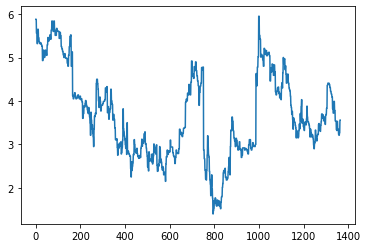

In [27]:
len(runningLog)

0

In [26]:
#if 
end_date.strftime('%Y-%m-%d')
#!= 
runningLog
#['date']
#.iloc[-1].strftime('%Y-%m-%d')


""


In [ ]:

BuyFundsPercent = .75
percentHeldOnSell = 1

strategies = []
holds = []

for f in futures3:
    #throwing a weird date error with one dataframe (had date outside of range)
    
    set = pd.DataFrame(f.result()).set_index('Date')[(end_date1+timedelta(days=1)).strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]
    #.dropna()
    
    if (len(set) != 0):
        print(set['Symbol'].unique())
        #display(set)
        #print(set)
        #plt.hist(set['sdev'], bins='auto')  # arguments are passed to np.histogram
        #plt.show()
        #plt.hist(set['ExpectedReturn'], bins='auto')  # arguments are passed to np.histogram
        #plt.show()
        #plt.hist(set['Forward Return'], bins='auto')  # arguments are passed to np.histogram
        #plt.show()        

        orderbook = pd.DataFrame()

        #temp = pd.DataFrame([dateToBeSold,1],columns=['date','qty'])
        column_names = ["date", "qty"]

        sellDates = pd.DataFrame(columns = column_names)
        
        data = symbols_data[symbols_data["Symbol"]==set['Symbol'].unique()[0]].set_index('Date')

        #set[dateindex2[1].strftime('%Y-%m-%d')]
        #need this becuase it's picking that extra date I set in yf.Download due to nyse having +1 day vs end_date in yf.Download
        for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index[:-1]:
        #pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index:
            #print(i)
        #for i in frequency[frequency.get_loc(end_date1):]:

            idate = i.strftime('%Y-%m-%d')        

            #process purchases
            #set index's are repeated
            if (idate in set.index.unique()):
                #print(idate)

                #innerSet = pd.DataFrame(set.set_index('Date').loc[idate]).transpose()
                innerSet = set.loc[idate]

                #if isinstance(innerSet, pd.DataFrame):
                    #print("pd")
                if isinstance(innerSet, pd.Series):
                    #print("series")
                    innerSet = pd.DataFrame(innerSet).transpose()

                #print(innerSet)
                types = innerSet.type.unique()
                #display(innerSet)

                for t in types:
                    innerSet_t = innerSet[innerSet['type']==t]
                    #print(innerSet[innerSet['type']==t])
                    #print(innerSet_t)

                    temp = pd.DataFrame()

                    #estRet = set.set_index('Date').loc[idate]['ExpectedReturn']
                    estRet = innerSet_t.loc[idate]['ExpectedReturn']

                    temp['orderside'] = ['buy']        

                    #if len(data[start_date.strftime('%Y-%m-%d'):idate])-1+n_forward>=len(data[start_date.strftime('%Y-%m-%d'):]):
                        #dateToBesold = np.nan    
                        #dateToBeSold = frequency[frequency.get_loc(idate)+n_forward].strftime('%Y-%m-%d')
                        #frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])+n_forward].strftime('%Y-%m-%d')
                        #temp['valueAtSale'] = np.nan
                    #else:
                    if (innerSet_t['type'][0] == strategy) or (innerSet_t['type'][0] == 'fbProphet') or (innerSet_t['type'][0]=='fbProphet+strategy'):
                        #dateToBeSold = data.iloc[len(data[start_date:idate])-1+n_forward].name.strftime('%Y-%m-%d') 
                        dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())+n_forward].strftime('%Y-%m-%d')
                        #frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])+n_forward].strftime('%Y-%m-%d')
                    else:
                        dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())+1].strftime('%Y-%m-%d')

                    #print(dateToBeSold)
                    #temp['valueAtSale'] = pd.DataFrame(data.iloc[len(data[start_date:idate])-1+n_forward]).transpose()['Close'].values[0]            
                    if dateToBeSold in data.index:                        
                        temp['valueAtSale'] = data.loc[dateToBeSold]['Close']                    
                    else:
                        temp['valueAtSale'] = np.nan

                    temp['date'] = [idate]
                    temp['valueAtPurchase'] = innerSet_t['Close'][0]
                    temp['estRet'] = estRet
                    temp['type'] = t
                    #innerSet_t['type'][0]
                    #temp['qty'] = Qty
                    temp['dateBought'] = idate        
                    temp['dateToBeSold'] = dateToBeSold

                    btemp = pd.DataFrame(columns = column_names)
                    btemp["date"]=[dateToBeSold]
                    btemp["type"]=t
                    #btemp["qty"]=[Qty]

                    #print(btemp)
                    sellDates = sellDates.append(btemp,ignore_index=True)

                    temp = temp.round(4)

                    orderbook = orderbook.append(temp,ignore_index=True)


        #for i in dateindex2:
        for i in sellDates.sort_values(by=['date'], ascending=True)['date'].unique():
        #sellDates.set_index('date').index:

            idate = i
            #.strftime('%Y-%m-%d')        

            #process sales

            #if (idate in sellDates.set_index('date').index): 

            dateTypes = sellDates.set_index('date').loc[idate]
            if isinstance(dateTypes, pd.Series):
                dateTypes = pd.DataFrame(dateTypes).transpose()

            types = dateTypes['type'].unique()

            for t in types:
                #print(t)
                if (t == strategy) or (t == 'fbProphet') or (t == 'fbProphet+strategy'):

                    dateBought = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())-n_forward].strftime('%Y-%m-%d')
                else:
                    dateBought = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())-1].strftime('%Y-%m-%d')

                innerSet = set.loc[dateBought]

                if isinstance(innerSet, pd.Series):
                    innerSet = pd.DataFrame(innerSet).transpose()

                innerSet_t = innerSet[innerSet['type']==t]   
                #print([innerSet_t['ExpectedReturn']])

                temp = pd.DataFrame()            

                dateToBeSold = idate
                temp['dateBought'] = [dateBought]
                temp['dateToBeSold'] = dateToBeSold
                temp['valueAtPurchase'] = data.loc[dateBought]['Close']
                temp['estRet'] = [innerSet_t['ExpectedReturn'][0]]
                if dateToBeSold in data.index:                        
                    temp['valueAtSale'] = data.loc[dateToBeSold]['Close']                    
                else:
                    temp['valueAtSale'] = np.nan

                temp['orderside'] = ['sell']   
                temp['type'] = [t]
                temp['date'] = [idate]
                #print(temp)

                temp = temp.round(4)

                orderbook = orderbook.append(temp,ignore_index=True)

                #counter=counter+1
                #print(counter)
                #print(idate)

        #filtered_orderbook = orderbook[((orderbook['type']=='MACD') & (orderbook['estRet']>=.0) )| ((orderbook['type']=='fbProphet') | (orderbook['type']==strategy) |((orderbook['type']=='H') & (orderbook['estRet']>=1) )|( (orderbook['type']=='adf') & (orderbook['estRet']>=.9)) )]
        filtered_orderbook = orderbook[(orderbook['type']=='fbProphet') | (orderbook['type']==strategy)]

        #display(orderbook.sort_values(by=['date','orderside'], ascending=True))

        funds = 1000
        BuyFundsPercent = 1
        percentHeldOnSell = 1

        buyLog = pd.DataFrame()
        sellLog = pd.DataFrame()
        runningLog = pd.DataFrame()

        held = 0
        upper = 0
        lower = 0

        #weights = [3,2,1]

        #weights2 = 1/np.array(weights)/sum(1/np.array(weights))

        weights2 = [.125, .25, .5, .75]
        
        for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index[:-1]:
        #for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index:            

            temp = pd.DataFrame()
            rtemp = pd.DataFrame()
            _temp = pd.DataFrame()

            t = i.strftime('%Y-%m-%d')

            subset = filtered_orderbook[filtered_orderbook['date']==t]

            gain = 0
            paid = 0

            if len(subset) != 0:
                #print(subset)

                sales = subset[subset['orderside'] == 'sell']        
                types_s = sales['type'].unique()

                for ts_ in types_s:

                    sales_t = sales[sales['type']==ts_]

                    if len(sales_t) != 0:                        

                        oldvalue = sales_t['valueAtPurchase'].values[0]

                        newvalue = sales_t['valueAtSale'].values[0]      

                        bl = buyLog.set_index('date').loc[datetime.datetime.strptime(sales_t['dateBought'].values[0], "%Y-%m-%d").date()]
                        #buyLog.set_index('date').loc[sales_t['dateBought'].values[0]]

                        if isinstance(bl, pd.Series):
                            bl = pd.DataFrame(bl).transpose()

                        Qty = bl[bl['type']==ts_]['qty'][0]

                        gain = gain + (newvalue * Qty)

                        _temp['date'] = [i]
                        _temp['type'] = [ts_]
                        _temp['qty'] = [Qty]

                        sellLog = pd.concat([sellLog,_temp])                

                purchases = subset[subset['orderside'] == 'buy']

                types_p = purchases['type'].unique()

                for tp in types_p:

                    purchases_t = purchases[purchases['type']==tp]

                    if len(purchases_t) != 0:

                        weights = [3,2,1]                

                        #print(tp)
                        if tp == 'adf': BuyFundsPercent_ = BuyFundsPercent * weights2[0]
                        if tp == 'H': BuyFundsPercent_ = BuyFundsPercent * weights2[0]
                        if tp == 'MACD': BuyFundsPercent_ = BuyFundsPercent * weights2[1]                
                        if tp == strategy: BuyFundsPercent_ = BuyFundsPercent * weights2[2]
                        if tp == 'fbProphet': BuyFundsPercent_ = BuyFundsPercent * weights2[3]   
                        if tp == 'fbProphet+strategy': BuyFundsPercent_ = BuyFundsPercent * weights2[3]   

                        ProportionOfFunds = funds * BuyFundsPercent_

                        Qty = ProportionOfFunds / purchases_t['valueAtPurchase'].values[0]
                        Qty = Qty.round(6)
                        #print(purchases['valueAtPurchase'].values[0])
                        #print("Qty purchased " + str(Qty.round(2)))

                        temp['date'] = [i]
                        temp['type'] = [tp]
                        temp['qty'] = [Qty]

                        paid = purchases_t['valueAtPurchase'].values[0]*Qty

                        #print("buy")
                        #print(temp)

                        buyLog = pd.concat([buyLog,temp])

                        #print(buyLog)

                        funds = funds - paid           

                funds = funds + gain

                rtemp['date'] =  [i]
                rtemp['funds'] =  [funds]

                if len(sellLog) != 0:
                    remainder = (sum(buyLog['qty'])-sum(sellLog['qty']))            

                else:
                    remainder = (sum(buyLog['qty']))

                rtemp['held'] = remainder

                #print(remainder)
                rtemp['value'] = remainder * data.loc[i.strftime('%Y-%m-%d')]['Close']
                rtemp['portValue'] = funds + remainder * data.loc[i.strftime('%Y-%m-%d')]['Close']
                #print(rtemp)

                #print("in " + str(gain))
                #print("out " + str(paid))
                #print("held: " + str(remainder))
                #print("Close Value: " + str(data.loc[i]['Close']))
                #print("held Value: " + str(remainder * data.loc[i]['Close']))
                #print("funds " + str(funds))
                #print("portValue " + str(funds + remainder * data.loc[i]['Close']))
                #print()

                runningLog = runningLog.append(rtemp)

        funds = 1000

        if len(runningLog) != 0:
            
            if end_date.strftime('%Y-%m-%d') != runningLog['date'].iloc[-1].strftime('%Y-%m-%d'):
                rl_temp = pd.DataFrame()
                rl_temp['date'] = [end_date]
                rl_temp['funds'] = [runningLog.iloc[-1]['funds']]
                rl_temp['held'] = [runningLog.iloc[-1]['held']]
                rl_temp['value'] = [runningLog.iloc[-1]['value']]
                rl_temp['portValue'] = [runningLog.iloc[-1]['portValue']]
                runningLog = runningLog.append(rl_temp)

                runningLog = runningLog.sort_values(by=['date'], ascending=True)

            if end_date1.strftime('%Y-%m-%d') != runningLog['date'].iloc[0].strftime('%Y-%m-%d'):
                rl_temp = pd.DataFrame()
                rl_temp['date'] = [end_date1]
                rl_temp['funds'] = [funds]
                rl_temp['held'] = [0]
                rl_temp['value'] = [0]
                rl_temp['portValue'] = [funds]
                runningLog = runningLog.append(rl_temp)

                runningLog = runningLog.sort_values(by=['date'], ascending=True)            

            #ret_data =  runningLog.set_index('date')['portValue'].pct_change()
            ret_data =  runningLog.set_index(pd.to_datetime(runningLog['date'], format='%Y-%m-%d'))['portValue'].pct_change()
            cumulative_ret_data = (ret_data + 1).cumprod()

            #ret_data2 = data[runningLog.set_index('date').index[1]:runningLog.set_index('date').index[-1]]['Close'].pct_change()
            ret_data2 = data[(end_date1+timedelta(days=1)).strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]['Close'].pct_change().copy()
            cum_ret_data2 = (ret_data2 + 1).cumprod()

            #sp500_data = benchData[runningLog.set_index('date').index[1]:runningLog.set_index('date').index[-1]]['Close'].pct_change()
            plt.plot(cumulative_ret_data,label=" strategy @ " + str(BuyFundsPercent) )

            #This is already plotted earlier
            #plt.plot(cum_ret_data2,label=" hold")        

            #runningLog

            #plt.show()
            strategies.append(cumulative_ret_data.iloc[-1])
            holds.append(cum_ret_data2.iloc[-1])
            print("strategy: " + str(cumulative_ret_data.iloc[-1]) + " vs hold: " + str(cum_ret_data2.iloc[-1]))

plt.legend(loc="upper left",fontsize=8)

plt.xticks(rotation=30) 
                    

['AMPY']
strategy: 0.9304442095129509 vs hold: 0.5946938357614435
['MDGL']
strategy: 1.2070581666641735 vs hold: 1.08807238683904
['BLFS']
strategy: 2.3831379652699995 vs hold: 3.242095788532747
['ESPR']
strategy: 0.77313443399 vs hold: 0.5899901671406401
['RNG']
strategy: 2.017239983929999 vs hold: 3.948338687435968
['SRPT']
strategy: 0.7716743704799996 vs hold: 0.7027536662768163
['KALV']
strategy: 1.67899022283 vs hold: 1.3454467778772983
['AVAV']


In [18]:

print("SP500: " + str(sp500_cumulative_ret_data.iloc[-1]))

print("Strategy: " + str(pd.DataFrame(strategies).mean().values[0]))
print("Hold: " + str(pd.DataFrame(holds).mean().values[0]))


SP500: 1.462132244750126
Strategy: 1.0831818703483256
Hold: 1.7847235084331088


In [ ]:
#plt.plot((set['ExpectedReturn']+1))
#plt.xticks(rotation=30) 
#len(set['ExpectedReturn']+1)

In [ ]:
#plt.hist(runningLog['portValue'].dropna().pct_change(), bins='auto')  # arguments are passed to np.histogram
#print(runningLog['portValue'].dropna().pct_change().sum())